# Conformal Prediction Intervals

# setup - regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [3]:
boston = load_boston()
features = boston["data"]
feature_names = boston["feature_names"]
labels = boston["target"]

In [4]:
df = pd.DataFrame(features)
df.columns = feature_names 
df["LABEL"] = labels

In [5]:
X = df.drop(columns=["LABEL"])
y = df["LABEL"]

In [6]:
X_train_and_cal, X_test, y_train_and_cal, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [7]:
X_train, X_cal, y_train, y_cal = train_test_split(X_train_and_cal, y_train_and_cal, test_size=0.5, random_state=1)

In [8]:
print(f"Training Set Shape: {X_train.shape}")
print(f"Calibration Set Shape: {X_cal.shape}")
print(f"Testing Set Shape: {X_test.shape}")

Training Set Shape: (202, 13)
Calibration Set Shape: (202, 13)
Testing Set Shape: (102, 13)


# conformal prediction - regression (not normalized, calibration)

In [9]:
# https://github.com/donlnz/nonconformist/blob/master/README.ipynb

In [ ]:
# https://scottlocklin.wordpress.com/2016/12/05/predicting-with-confidence-the-best-machine-learning-idea-you-never-heard-of/

In [10]:
from nonconformist.nc import NcFactory
from nonconformist.cp import IcpRegressor

In [11]:
# underlying model

In [12]:
from sklearn.ensemble import RandomForestRegressor

In [13]:
clf_regression = RandomForestRegressor(n_estimators=500, 
                                       max_features=0.5,
                                       min_samples_leaf=1, 
                                       n_jobs=-1, 
                                       oob_score=True)

In [14]:
# nonconformity function 

In [15]:
nc_regression = NcFactory.create_nc(clf_regression)

In [16]:
# inductive conformal regressor

In [17]:
icp_regression = IcpRegressor(nc_regression)	

In [18]:
# fit training set

In [19]:
icp_regression.fit(X_train, y_train)

In [20]:
# predictions 

In [21]:
clf_predictions = clf_regression.predict(X_test)

In [22]:
# calibrate icp

In [23]:
icp_regression.calibrate(X_cal, y_cal)

In [24]:
# prediction intervals 

In [163]:
epsilon = 0.05

In [164]:
prediction_intervals = icp_regression.predict(np.array(X_test), significance=epsilon)

In [165]:
prediction_ints_df = pd.DataFrame(prediction_intervals)
prediction_ints_df.columns = ["LOWER","UPPER"]

In [166]:
# results

In [167]:
actual_prediction_df = pd.DataFrame({'ACTUAL' : y_test,
                                     'PREDICTION' : clf_predictions}).reset_index(drop=True)
results_df = pd.concat([actual_prediction_df, prediction_ints_df], axis=1)

In [168]:
results_df

,ACTUAL,PREDICTION,LOWER,UPPER
0,28.2,29.0080,22.7870,35.2290
1,23.9,27.5370,21.3160,33.7580
2,16.6,19.9540,13.7330,26.1750
3,22.0,21.0512,14.8302,27.2722
4,20.8,20.0862,13.8652,26.3072
...,...,...,...,...
97,22.9,24.3588,18.1378,30.5798
98,44.8,41.2264,35.0054,47.4474
99,21.7,20.7402,14.5192,26.9612
100,10.2,17.5524,11.3314,23.7734


In [169]:
results_df_sorted = results_df.sort_values(by='ACTUAL').reset_index(drop=True)

(0, 60)

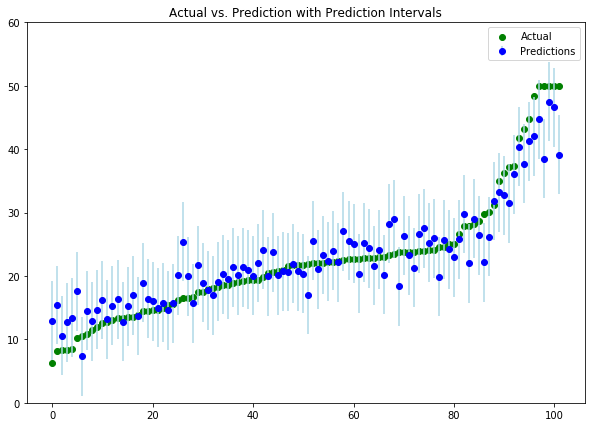

In [170]:
plt.figure(figsize=[10,7])
plt.scatter(results_df_sorted.index,
            results_df_sorted.ACTUAL,
            color='green')
plt.errorbar(results_df_sorted.index,
             results_df_sorted.PREDICTION,
             yerr=[results_df_sorted.PREDICTION - results_df_sorted.LOWER, 
                   results_df_sorted.UPPER - results_df_sorted.PREDICTION],
             ecolor='lightblue', 
             fmt='bo',
             elinewidth=0)
plt.title("Actual vs. Prediction with Prediction Intervals")
plt.legend(['Actual','Predictions'])
plt.ylim([0,60])

In [171]:
correct = 0
for each_row in results_df_sorted.itertuples():
    if each_row.LOWER <= each_row.ACTUAL <= each_row.UPPER:
        correct += 1
print(f"Percent of Predictions +/- Interval that Include Actual Value: {correct/results_df.shape[0]}")

Percent of Predictions +/- Interval that Include Actual Value: 0.9215686274509803


# conformal prediction - regression (normalized, different intervals)

In [172]:
# https://github.com/donlnz/nonconformist/blob/master/examples/icp_regression_tree.py

In [173]:
from sklearn.neighbors import KNeighborsRegressor
from nonconformist.base import RegressorAdapter
from nonconformist.icp import IcpRegressor
from nonconformist.nc import RegressorNc, AbsErrorErrFunc, RegressorNormalizer

In [174]:
# underlying model

In [175]:
from sklearn.ensemble import RandomForestRegressor

In [176]:
clf_regression_normalized = RandomForestRegressor(n_estimators=500, 
                                                  max_features=0.5,
                                                  min_samples_leaf=1, 
                                                  n_jobs=-1, 
                                                  oob_score=True)

In [177]:
underlying_model = RegressorAdapter(clf_regression_normalized)

In [178]:
# normalization 

In [179]:
#normalizing_model = RegressorAdapter(KNeighborsRegressor(n_neighbors=25))
normalizing_model = RegressorAdapter(RandomForestRegressor())

In [180]:
normalizer = RegressorNormalizer(underlying_model, normalizing_model, AbsErrorErrFunc())

In [181]:
# nonconformity function 

In [182]:
nc_regression_normalized = RegressorNc(underlying_model, AbsErrorErrFunc(), normalizer)

In [183]:
# inductive conformal regressor

In [184]:
icp_regression_normalized = IcpRegressor(nc_regression_normalized)

In [185]:
# fit training set

In [186]:
icp_regression_normalized.fit(X_train, y_train)

In [187]:
# predictions 

In [188]:
clf_predictions_normalized = clf_regression_normalized.predict(X_test)

In [189]:
# calibrate icp

In [190]:
icp_regression_normalized.calibrate(X_cal, y_cal)

In [191]:
# prediction intervals 

In [192]:
epsilon = 0.1

In [193]:
prediction_intervals_normalized = icp_regression_normalized.predict(np.array(X_test), significance=epsilon)

In [194]:
prediction_ints_normalized_df = pd.DataFrame(prediction_intervals_normalized)
prediction_ints_normalized_df.columns = ["LOWER","UPPER"]

In [195]:
# results

In [196]:
actual_prediction_normalized_df = pd.DataFrame({'ACTUAL' : y_test,
                                                'PREDICTION' : clf_predictions}).reset_index(drop=True)
results_normalized_df = pd.concat([actual_prediction_normalized_df, prediction_ints_normalized_df], axis=1)

In [197]:
results_normalized_df

,ACTUAL,PREDICTION,LOWER,UPPER
0,28.2,29.0080,26.069965,31.418035
1,23.9,27.5370,23.506595,31.212605
2,16.6,19.9540,10.933038,28.490962
3,22.0,21.0512,19.220894,22.540306
4,20.8,20.0862,15.877932,23.748868
...,...,...,...,...
97,22.9,24.3588,20.649084,28.188516
98,44.8,41.2264,22.000840,61.557160
99,21.7,20.7402,18.879767,22.714633
100,10.2,17.5524,9.159689,25.515911


In [198]:
results_df_normalized_sorted = results_normalized_df.sort_values(by='ACTUAL').reset_index(drop=True)

(0, 60)

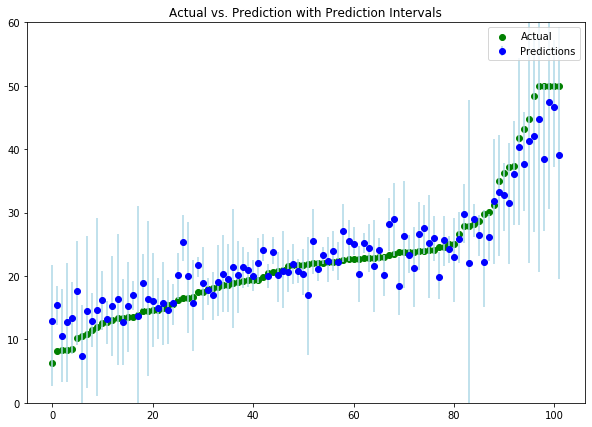

In [199]:
plt.figure(figsize=[10,7])
plt.scatter(results_df_normalized_sorted.index,
            results_df_normalized_sorted.ACTUAL,
            color='green')
plt.errorbar(results_df_normalized_sorted.index,
             results_df_normalized_sorted.PREDICTION,
             yerr=[results_df_normalized_sorted.PREDICTION - results_df_normalized_sorted.LOWER, 
                   results_df_normalized_sorted.UPPER - results_df_normalized_sorted.PREDICTION],
             ecolor='lightblue', 
             fmt='bo',
             elinewidth=0)
plt.title("Actual vs. Prediction with Prediction Intervals")
plt.legend(['Actual','Predictions'])
plt.ylim([0,60])

In [200]:
correct = 0
for each_row in results_df_normalized_sorted.itertuples():
    if each_row.LOWER <= each_row.ACTUAL <= each_row.UPPER:
        correct += 1
print(f"Percent of Predictions +/- Interval that Include Actual Value: {correct/results_df.shape[0]}")

Percent of Predictions +/- Interval that Include Actual Value: 0.8627450980392157


In [ ]:
# https://github.com/venkatasandeepd/conformal_prediction/blob/master/KNN_Conformal.ipynb